# Laboratorio 6 - Análisis de Redes Sociales

#### Diego García 22404
#### Andrés Ortega 22305
#### Esteban Zambrano 22119

**Link del repositorio:**

https://github.com/DiegoGarV/lab6-DS

*PROBLEMA 2 - BERNARDO ARÉVALO*

## Limpieza de datos

In [ ]:
# pip install nltk
# pip install emoji
# pip install wordcloud
# !pip install networkx pyvis
# !pip install python-igraph leidenalg

In [133]:
import os, json, re
from typing import Any, Dict, List
import pandas as pd

# Carpeta de datos / salida
os.makedirs("data", exist_ok=True)
INPUT_TXT = "../data/tioberny.txt" 

OUTPUT_CSV = "../data/converted_data.csv"
print("Leyendo de:", INPUT_TXT)


Leyendo de: ../data/tioberny.txt


Los json con los datos incluyen una gran cantidad de metadata, de la cuál no toda es necesaria. Tomando en cuenta los datos que se iban a analizar, se dicidió solo tomar en cuenta el username, la información del tweet, los hashtags y las menciones. Además, si en un tweet se cita a otro, se tomó también como un dato importante, ya que crea una interacción. Este se va tratar por aparte de las menciones. Con esto se obtendrá el csv inicial para el laboratorio.

In [134]:
from typing import Any, Dict, List

# Detecta codificación
def sniff_encoding(path: str) -> str:
    with open(path, "rb") as f:
        raw = f.read(4)
    if raw.startswith(b"\xff\xfe\x00\x00") or raw.startswith(b"\x00\x00\xfe\xff"):
        return "utf-32"
    if raw.startswith(b"\xff\xfe") or raw.startswith(b"\xfe\xff"):
        return "utf-16"
    if raw.startswith(b"\xef\xbb\xbf"):
        return "utf-8-sig"
    return "utf-8"


"""
1) Detecta codificación.
2) Intenta parsear TODO como JSON (lista u objeto).
3) Si falla, interpreta como JSONL (una línea = un objeto JSON).
Ignora líneas vacías o malformadas en modo JSONL.
"""
def load_tweets_from_txt(path: str) -> List[Dict[str, Any]]:
    enc = sniff_encoding(path)
    print(f"[load] Codificación detectada: {enc}")

    # Caso 1: archivo entero como JSON
    with open(path, "r", encoding=enc) as f:
        content = f.read().strip()

    try:
        parsed = json.loads(content)
        if isinstance(parsed, list):
            return parsed
        elif isinstance(parsed, dict):
            return [parsed]
    except Exception:
        pass  # seguimos con JSONL

    # Caso 2: JSON Lines (una línea por objeto)
    tweets: List[Dict[str, Any]] = []
    bad, total = 0, 0
    with open(path, "r", encoding=enc) as f:
        for line in f:
            line = line.strip()
            if not line or not line.startswith("{"):
                continue
            total += 1
            try:
                obj = json.loads(line)
                if isinstance(obj, dict):
                    tweets.append(obj)
            except Exception:
                bad += 1
                continue

    print(f"[load] Registros leídos: {len(tweets)} | líneas con error: {bad}/{total}")
    return tweets

# Ejecutar carga
tweets_raw = load_tweets_from_txt(INPUT_TXT)
len(tweets_raw)


[load] Codificación detectada: utf-16
[load] Registros leídos: 5019 | líneas con error: 0/5019


5019

In [135]:
def get_username(obj: Dict[str, Any]) -> str:
    u = obj.get("user") or {}
    return (u.get("username") or "").strip() if isinstance(u, dict) else ""

def get_raw_content(obj: Dict[str, Any]) -> str:
    return (obj.get("rawContent") or "").strip()

def get_hashtags(obj: Dict[str, Any]) -> List[str]:
    hs = obj.get("hashtags", [])
    # Pueden venir como lista de strings o lista de objetos
    out = []
    if isinstance(hs, list):
        for h in hs:
            if isinstance(h, str):
                out.append(h.strip())
            elif isinstance(h, dict):
                # por si viniera como {"text": "algo"}
                txt = h.get("text") or h.get("tag") or ""
                if txt:
                    out.append(str(txt).strip())
    return [h for h in out if h]

def get_mentions(obj: Dict[str, Any]) -> List[str]:
    ms = obj.get("mentionedUsers", [])
    out = []
    if isinstance(ms, list):
        for m in ms:
            if isinstance(m, dict):
                u = m.get("username")
                if u:
                    out.append(str(u).strip())
            elif isinstance(m, str):
                out.append(m.strip())
    return [m for m in out if m]

def get_quoted(obj: Dict[str, Any]) -> Dict[str, Any]:
    qt = obj.get("quotedTweet")
    return qt if isinstance(qt, dict) else {}

# Extrae el username del tweet citado (si existe)
def get_from_user_for_row(obj: Dict[str, Any]) -> str:
    qt = get_quoted(obj)
    return get_username(qt) if qt else ""


In [136]:
def row_from_tweet(obj: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "Username": get_username(obj),
        "rawTweet": get_raw_content(obj),
        "hashtags": ", ".join(get_hashtags(obj)),     # en CSV quedará como texto separado por coma
        "mentions": ", ".join(get_mentions(obj)),     # idem
        "fromUser": get_from_user_for_row(obj),       # usuario del tweet citado por ESTA FILA (si existe)
    }


"""
Agrega una fila por 'obj' y luego recursivamente por cada quotedTweet anidado.
Usa seen_ids para evitar ciclos/duplicados si se repiten objetos por ID.
"""
def flatten_with_quotes(obj: Dict[str, Any], rows: List[Dict[str, Any]], seen_ids: set):
    # Intentar usar 'id' para deduplicación (si existe)
    obj_id = obj.get("id") or obj.get("id_str")
    if obj_id is not None:
        if obj_id in seen_ids:
            return
        seen_ids.add(obj_id)

    # Fila del tweet actual
    rows.append(row_from_tweet(obj))

    # Si tiene quotedTweet, aplanar recursivamente
    qt = get_quoted(obj)
    if qt:
        flatten_with_quotes(qt, rows, seen_ids)

def build_flat_table(objs: List[Dict[str, Any]]) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    seen_ids: set = set()
    for obj in objs:
        if isinstance(obj, dict):
            flatten_with_quotes(obj, rows, seen_ids)
    # Orden de columnas exactamente como pediste
    cols = ["Username", "rawTweet", "hashtags", "mentions", "fromUser"]
    df = pd.DataFrame(rows, columns=cols)
    # Limpieza básica de espacios
    for c in cols:
        df[c] = df[c].fillna("").astype(str).str.strip()
    return df

df_converted = build_flat_table(tweets_raw)
print(df_converted.shape)
df_converted.head(11)


(4944, 5)


,Username,rawTweet,hashtags,mentions,fromUser
0,La_ReVoluZzion,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",,"usembassyguate, 48CantonesToto, USAIDGuate, UE...",XelaNewsGt
1,XelaNewsGt,#URGENTE Lo que los medios #faferos no informa...,"URGENTE, faferos, BernardoArévalo, NebajQuiché...",,
2,M24095273,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,,"IvanDuque, BArevalodeLeon",
3,carlosalbesc,@IvanDuque @BArevalodeLeon Entre Ellos se enti...,,"IvanDuque, BArevalodeLeon",
4,Brenda_AGN,El presidente @BArevalodeLeon y la vicepreside...,,"BArevalodeLeon, KarinHerreraVP, AGN_noticias, ...",
5,Roberto28338166,@BArevalodeLeon El muy hijo de puta inyectó co...,,BArevalodeLeon,
6,LuisEnr36669555,@EmisorasUnidas @BArevalodeLeon Y que de bueno...,,"EmisorasUnidas, BArevalodeLeon",
7,keratox1,@IvanDuque @BArevalodeLeon Productiva es que g...,,"IvanDuque, BArevalodeLeon",
8,Radio_TGW,"@KarinHerreraVP El presidente de la República,...",,"KarinHerreraVP, BArevalodeLeon",
9,Corleone_62,"@mys_servicios @BArevalodeLeon No tampoco, ese...",,"mys_servicios, BArevalodeLeon",


In [137]:
df_converted.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
print(f"✓ Archivo guardado en: {OUTPUT_CSV}")

✓ Archivo guardado en: ../data/converted_data.csv


## Preprocesamiento de los datos

In [138]:
import os
import pandas as pd

INPUT_CSV = "../data/converted_data.csv"

df = pd.read_csv(
    INPUT_CSV,
    dtype={"Username": str, "rawTweet": str, "hashtags": str, "mentions": str, "fromUser": str}
).fillna("")

df.info()
display(df.head())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4944 entries, 0 to 4943
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Username  4944 non-null   object
 1   rawTweet  4944 non-null   object
 2   hashtags  4944 non-null   object
 3   mentions  4944 non-null   object
 4   fromUser  4944 non-null   object
dtypes: object(5)
memory usage: 193.3+ KB


,Username,rawTweet,hashtags,mentions,fromUser
0,La_ReVoluZzion,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",,"usembassyguate, 48CantonesToto, USAIDGuate, UE...",XelaNewsGt
1,XelaNewsGt,#URGENTE Lo que los medios #faferos no informa...,"URGENTE, faferos, BernardoArévalo, NebajQuiché...",,
2,M24095273,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,,"IvanDuque, BArevalodeLeon",
3,carlosalbesc,@IvanDuque @BArevalodeLeon Entre Ellos se enti...,,"IvanDuque, BArevalodeLeon",
4,Brenda_AGN,El presidente @BArevalodeLeon y la vicepreside...,,"BArevalodeLeon, KarinHerreraVP, AGN_noticias, ...",


Username    0
rawTweet    0
hashtags    0
mentions    0
fromUser    0
dtype: int64

In [139]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)

STOPWORDS_ES = set(stopwords.words('spanish'))

STOPWORDS_ES.update({
    "rt","vía","via"
})

len(STOPWORDS_ES)


316

En este caso, como también se quiere hacer un análisis de emociones, los emojis se van a guardar en una columna separada, pero se van a eliminar del tweet para la columna de "clean".

In [140]:
import re
import emoji

# URLs
URL_RE = re.compile(r"https?://\S+|www\.\S+", flags=re.IGNORECASE)

# Extrae la lista de emojis en el texto (mantiene repeticiones)
def list_emojis(s: str):
    return [m["emoji"] for m in emoji.emoji_list(s or "")]

def remove_emojis(s: str) -> str:
    return emoji.replace_emoji(s or "", replace=" ")

def clean_tweet_text(s: str, stopset: set) -> str:
    if not isinstance(s, str):
        return ""

    # 1) minúsculas
    s = s.lower()

    # 2) quitar urls
    s = URL_RE.sub(" ", s)

    # 3) quitar emojis
    s = remove_emojis(s)

    # 4) quitar @ y # pero conservar el resto
    s = s.replace("@", " ").replace("#", " ")

    # 5) quitar signos de puntuación/símbolos (mantener letras a-z + acentos y espacios)
    s = re.sub(r"[^0-9a-záéíóúüñ\s]", " ", s)

    # 6) normalizar espacios
    s = re.sub(r"\s+", " ", s).strip()

    # 7) tokenización simple + filtros por dígitos y stopwords
    tokens = []
    for tok in s.split():
        if any(ch.isdigit() for ch in tok):  # descartar tokens con dígitos
            continue
        if tok in stopset:
            continue
        tokens.append(tok)

    return " ".join(tokens)


In [141]:
# Extrae emojis y crea columnas auxiliares
df["emojis"] = df["rawTweet"].apply(list_emojis)                 # lista de emojis
df["emojis_str"] = df["emojis"].apply(lambda arr: " ".join(arr)) # útil para CSV más adelante
df["emoji_count"] = df["emojis"].apply(len)

# Crea clean_tweet SIN emojis
df["clean_tweet"] = df["rawTweet"].apply(lambda s: clean_tweet_text(s, STOPWORDS_ES))

df[["rawTweet","emojis_str","emoji_count","clean_tweet"]].head(20)


,rawTweet,emojis_str,emoji_count,clean_tweet
0,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",,0,confirmado compañeres impuesto usembassyguate ...
1,#URGENTE Lo que los medios #faferos no informa...,🇫🇷,1,urgente medios faferos informaron ayer acerca ...
2,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,,0,ivanduque barevalodeleon usaste pegasus espiar...
3,@IvanDuque @BArevalodeLeon Entre Ellos se enti...,,0,ivanduque barevalodeleon entienden bien cuadra...
4,El presidente @BArevalodeLeon y la vicepreside...,,0,presidente barevalodeleon vicepresidenta karin...
5,@BArevalodeLeon El muy hijo de puta inyectó co...,,0,barevalodeleon hijo puta inyectó enfermedades ...
6,@EmisorasUnidas @BArevalodeLeon Y que de bueno...,,0,emisorasunidas barevalodeleon bueno trae guate...
7,@IvanDuque @BArevalodeLeon Productiva es que g...,,0,ivanduque barevalodeleon productiva genere pro...
8,"@KarinHerreraVP El presidente de la República,...",,0,karinherreravp presidente república barevalode...
9,"@mys_servicios @BArevalodeLeon No tampoco, ese...",,0,mys servicios barevalodeleon tampoco izmierda ...


In [142]:
n0 = len(df)

# --- Duplicados EXACTOS (en todas las columnas) ---
cols_base = ["Username","rawTweet","hashtags","mentions","fromUser","clean_tweet","emojis_str","emoji_count"]
cols_exist = [c for c in cols_base if c in df.columns]
df = df.drop_duplicates(subset=cols_exist, keep="first").reset_index(drop=True)
n1 = len(df)
print(f"Exactos en {cols_exist}: {n0-n1} filas eliminadas. Total: {n1}")

# --- Duplicados por rawTweet NORMALIZADO ---
df["_raw_norm"] = (
    df["rawTweet"]
      .astype(str)
      .str.lower()
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
)
df = df.drop_duplicates(subset=["_raw_norm"], keep="first").drop(columns=["_raw_norm"]).reset_index(drop=True)
n2 = len(df)
print(f"Por 'rawTweet' normalizado: {n1-n2} filas eliminadas. Total: {n2}")

# --- Duplicados por CONTENIDO LIMPIO (clean_tweet) ---
df = df.drop_duplicates(subset=["clean_tweet"], keep="first").reset_index(drop=True)
n3 = len(df)
print(f"Por 'clean_tweet': {n2-n3} filas eliminadas. Total final: {n3}")

print(f"\nResumen: eliminadas {n0-n3} de {n0} filas. Dataset final: {len(df)}")


Exactos en ['Username', 'rawTweet', 'hashtags', 'mentions', 'fromUser', 'clean_tweet', 'emojis_str', 'emoji_count']: 3 filas eliminadas. Total: 4941
Por 'rawTweet' normalizado: 8 filas eliminadas. Total: 4933
Por 'clean_tweet': 245 filas eliminadas. Total final: 4688

Resumen: eliminadas 256 de 4944 filas. Dataset final: 4688


Se hacen las relaciones según las menciones, retweets y replies.

In [143]:
import re
import numpy as np
import pandas as pd

# Manejo de menciones
def parse_mentions_field(x: str):
    if not isinstance(x, str) or not x.strip():
        return []
    # separar por coma y limpiar
    parts = [p.strip().lstrip('@').lower() for p in x.split(',') if p.strip()]
    out = []
    for p in parts:
        if not p:
            continue
        # fallback por si vinieran espacios sin comas
        if ' ' in p:
            out.extend([q.strip().lstrip('@').lower() for q in p.split() if q.strip()])
        else:
            out.append(p)
    # filtra vacíos
    return [m for m in out if m]

RT_PATTERN    = re.compile(r'^\s*rt\s+@([a-z0-9_]{1,15})', re.IGNORECASE)
REPLY_PATTERN = re.compile(r'^\s*@([a-z0-9_]{1,15})',     re.IGNORECASE)

# Manejo de retweets
def get_retweet_target(text: str):
    if not isinstance(text, str): 
        return None
    m = RT_PATTERN.search(text)
    return m.group(1).lower() if m else None

# Manejo de replies
def get_reply_target(text: str):
    if not isinstance(text, str): 
        return None
    m = REPLY_PATTERN.search(text)
    return m.group(1).lower() if m else None

"""
Genera edges dirigidos:
    - mention: Username -> cada @mencion
    - quote:   Username -> fromUser (si no vacío)
    - retweet: Username -> @usuario si texto inicia con 'RT @usuario'
    - reply:   Username -> @usuario si texto inicia con '@usuario'
Devuelve DataFrame: [source, target, interaction, weight]
"""
def build_edges(df: pd.DataFrame) -> pd.DataFrame:
    edges = []

    for _, row in df.iterrows():
        src = (row.get("Username") or "").strip()
        if not src:
            continue
        src_l = src.lower()

        # Mentions
        for m in parse_mentions_field(row.get("mentions", "")):
            if m and m != src_l:
                edges.append((src_l, m, "mention"))

        # Quote
        q = (row.get("fromUser") or "").strip().lower()
        if q and q != src_l:
            edges.append((src_l, q, "quote"))

        # Retweet (heurístico)
        rt = get_retweet_target(row.get("rawTweet", ""))
        if rt and rt != src_l:
            edges.append((src_l, rt, "retweet"))

        # Reply (heurístico)
        rp = get_reply_target(row.get("rawTweet", ""))
        if rp and rp != src_l:
            edges.append((src_l, rp, "reply"))

    if not edges:
        return pd.DataFrame(columns=["source","target","interaction","weight"])

    edges_df = pd.DataFrame(edges, columns=["source","target","interaction"])
    edges_df["weight"] = 1

    # Agregar pesos por (source, target, interaction)
    edges_agg = (edges_df
                 .groupby(["source","target","interaction"], as_index=False)["weight"]
                 .sum()
                 .sort_values(["weight","source","target"], ascending=[False, True, True])
                 .reset_index(drop=True))
    return edges_agg

edges = build_edges(df)
print("Edges construidos:", edges.shape)
edges.head(10)


Edges construidos: (15701, 4)


,source,target,interaction,weight
0,elrevoltijogt,barevalodeleon,mention,42
1,benitoc67601310,barevalodeleon,mention,30
2,elrevoltijogt,bancadasemilla,mention,30
3,ialmgg,barevalodeleon,mention,21
4,diariodeca,wendiv_dca,mention,18
5,dupin07,barevalodeleon,mention,18
6,vvj_gt,barevalodeleon,mention,18
7,diariodeca,barevalodeleon,mention,16
8,diariodeca,mmaczdca,mention,16
9,anti_chairosgt,barevalodeleon,mention,15


Se hace una matriz de adyacencia para ver como se relacionan los usuarios

In [144]:
# Matriz de adyacencia
if not edges.empty:
    adj = (edges.groupby(["source","target"])["weight"]
                 .sum()
                 .unstack(fill_value=0)
                 .astype(int)
          )
    print("Adjacency shape:", adj.shape)
    adj.head(5)
else:
    adj = pd.DataFrame()


Adjacency shape: (2465, 1066)


Se pasa todo a csv limpios.

In [145]:
# Guardar limpio principal
CLEAN_CSV = "../data/clean_data.csv"
cols_to_keep = [c for c in [
    "Username","rawTweet","hashtags","mentions","fromUser",
    "clean_tweet","emojis_str","emoji_count"
] if c in df.columns]

df[cols_to_keep].to_csv(CLEAN_CSV, index=False, encoding="utf-8")
print(f"✓ Guardado dataset limpio en {CLEAN_CSV} (filas: {len(df)})")

# Guardar edges
EDGES_CSV = "../data/network_edges.csv"
edges.to_csv(EDGES_CSV, index=False, encoding="utf-8")
print(f"✓ Guardado aristas en {EDGES_CSV} (filas: {len(edges)})")

# Guardar matriz de adyacencia
if not adj.empty:
    ADJ_CSV = "../data/network_adjacency.csv"
    adj.to_csv(ADJ_CSV, encoding="utf-8")
    print(f"✓ Guardada matriz de adyacencia en {ADJ_CSV} (shape: {adj.shape})")


✓ Guardado dataset limpio en ../data/clean_data.csv (filas: 4688)
✓ Guardado aristas en ../data/network_edges.csv (filas: 15701)
✓ Guardada matriz de adyacencia en ../data/network_adjacency.csv (shape: (2465, 1066))


## Análisis exploratorio

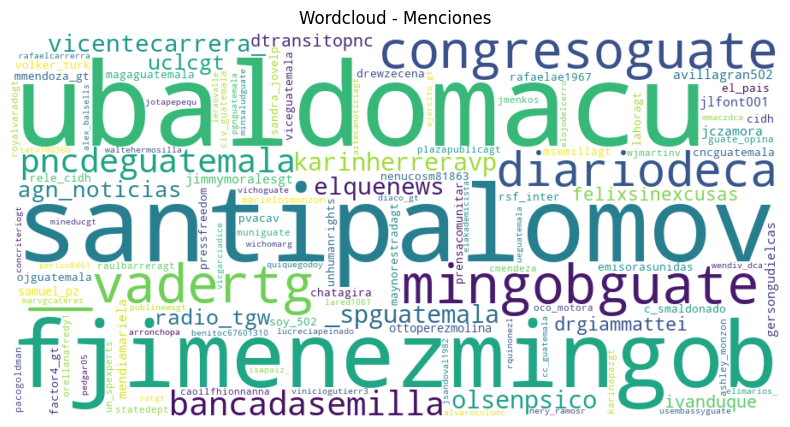

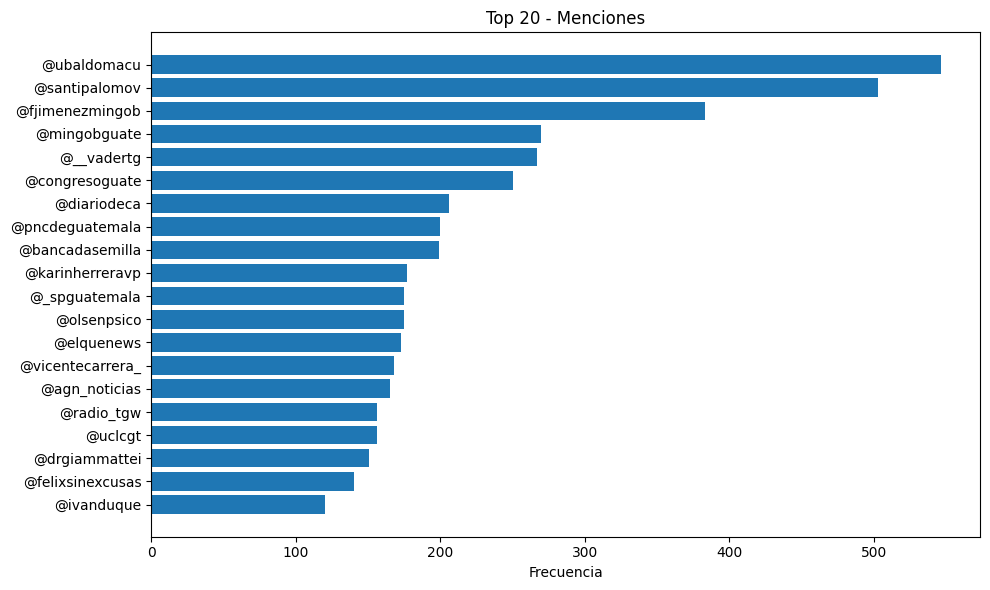

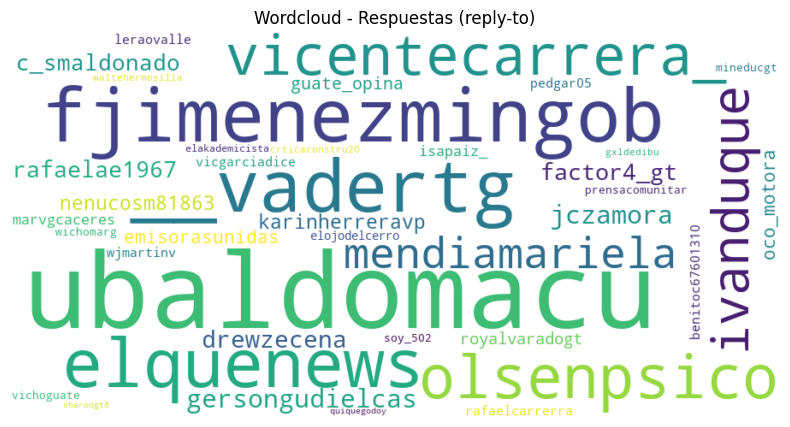

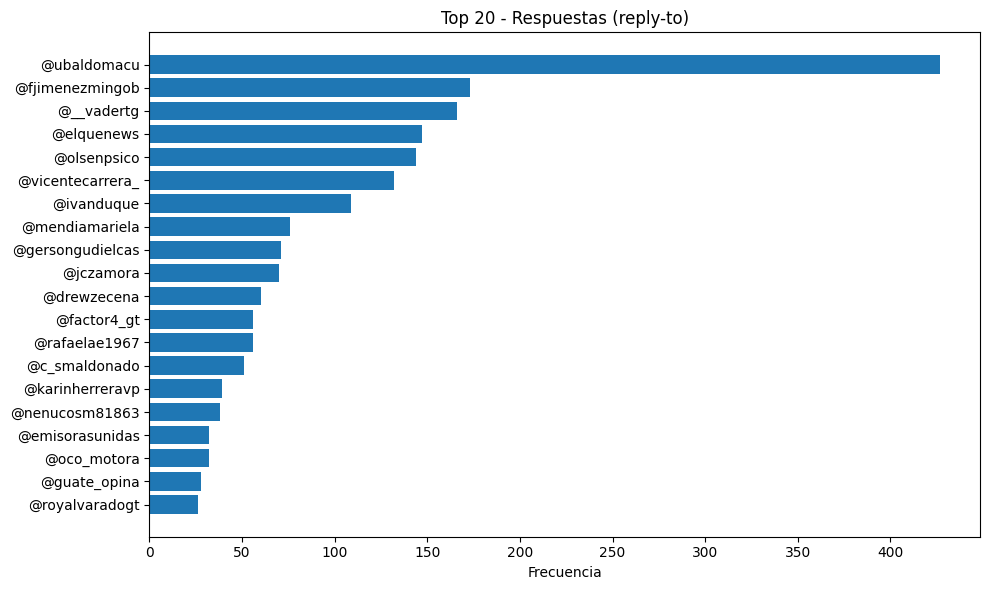

(sin datos para Wordcloud - Retweets (RT targets))
(sin datos para Top 20 - Retweets (RT targets))


In [146]:
import re
from collections import Counter
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Helpers
HANDLE_RE = re.compile(r'@([A-Za-z0-9_]{1,50})')
RT_RE = re.compile(r'^\s*rt\s+@([A-Za-z0-9_]{1,50})', flags=re.IGNORECASE)
REPLY_RE = re.compile(r'^\s*@([A-Za-z0-9_]{1,50})')

STOP_HANDLES = {
    'barevalodeleon','guatemalagob','mpguatemala','usaidguate'
}

def _norm_handle(h):
    return h.lower().strip('@')

def flatten_handles(series_or_listlike):
    handles = []
    for x in series_or_listlike.dropna():
        if isinstance(x, list):
            handles.extend([_norm_handle(h) for h in x])
        elif isinstance(x, str):
            if x.strip().startswith('[') and x.strip().endswith(']'):
                try:
                    parsed = eval(x)
                    handles.extend([_norm_handle(h) for h in parsed])
                except Exception:
                    handles.extend([_norm_handle(h) for h in HANDLE_RE.findall(x)])
            else:
                handles.extend([_norm_handle(h) for h in HANDLE_RE.findall(x)])
    return [h for h in handles if h and h not in STOP_HANDLES]

def extract_retweet_targets(raw_text_series: pd.Series):
    # captura a quién se retuitea
    rts = []
    for t in raw_text_series.dropna().astype(str):
        m = RT_RE.match(t)
        if m:
            rts.append(_norm_handle(m.group(1)))
    return [h for h in rts if h and h not in STOP_HANDLES]

def extract_reply_targets(raw_text_series: pd.Series):
    # captura respuestas al inicio del tweet
    reps = []
    for t in raw_text_series.dropna().astype(str):
        m = REPLY_RE.match(t)
        if m:
            reps.append(_norm_handle(m.group(1)))
    return [h for h in reps if h and h not in STOP_HANDLES]

def plot_wordcloud_from_handles(handles, title):
    if not handles:
        print(f"(sin datos para {title})")
        return
    text = " ".join(handles)
    wc = WordCloud(width=900, height=450, background_color='white',
                   collocations=False, min_font_size=10).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def plot_top_bar(counter, title, topn=20):
    if not counter:
        print(f"(sin datos para {title})")
        return
    items = counter.most_common(topn)
    labels = [f"@{k}" for k,_ in items]
    vals = [v for _,v in items]
    plt.figure(figsize=(10,6))
    plt.barh(labels, vals)
    plt.gca().invert_yaxis()
    plt.xlabel("Frecuencia")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Menciones
mentions_handles = flatten_handles(df.get('mentions', pd.Series(dtype=object)))
mentions_handles += flatten_handles(df['rawTweet'].apply(lambda t: HANDLE_RE.findall(t) if isinstance(t,str) else []))
mentions_counter = Counter(mentions_handles)

plot_wordcloud_from_handles(mentions_handles, "Wordcloud - Menciones")
plot_top_bar(mentions_counter, "Top 20 - Menciones")

# Respuestas
reply_handles = extract_reply_targets(df['rawTweet'])
reply_counter = Counter(reply_handles)

plot_wordcloud_from_handles(reply_handles, "Wordcloud - Respuestas (reply-to)")
plot_top_bar(reply_counter, "Top 20 - Respuestas (reply-to)")

# Retweets
rt_handles = extract_retweet_targets(df['rawTweet'])
rt_counter = Counter(rt_handles)

plot_wordcloud_from_handles(rt_handles, "Wordcloud - Retweets (RT targets)")
plot_top_bar(rt_counter, "Top 20 - Retweets (RT targets)")


In [147]:
from collections import Counter

# Totales
num_tweets = len(df)
num_users = df['Username'].nunique()

# Top hashtags (contando letras, no hashtags completos)
chars = []
for x in df['hashtags'].dropna().astype(str):
    for ch in x.lower():
        if ch.isalpha():      # solo letras
            chars.append(ch)

top_hashtags = Counter(chars).most_common(10)

print(f"Número total de tweets: {num_tweets} \nUsuarios únicos: {num_users} \nTop hashtags: {top_hashtags}")


Número total de tweets: 4688 
Usuarios únicos: 2535 
Top hashtags: [('a', 648), ('e', 517), ('n', 303), ('o', 278), ('l', 278), ('t', 273), ('r', 255), ('i', 250), ('s', 241), ('u', 218)]


El análisis exploratorio de la colección de datos permitió identificar las características esenciales de la conversación. Se recopilaron 4688 tweets provenientes de 2535 usuarios distintos, lo que evidencia que la red es amplia y relativamente diversa, con una participación significativa de voces en el debate. Se observó que los hashtags más frecuentes aparecen como caracteres individuales debido a la forma en que fueron almacenados; esto representa un impedimento durante el preprocesamiento. No obstante, las nubes de palabras corroboran que el diálogo está dominado por términos vinculados al gobierno, la política del país y el presidente Bernardo Arévalo.

Respecto a las menciones, los usuarios más sobresalientes fueron @ubaldomacu, @santipalomov, @fjimenezmingob, @mingobguate y @__vadertg. Esto demuestra que las interacciones se enfocan en entidades estatales y figuras políticas importantes. Asimismo, al analizar las respuestas (reply-to), se descubrió que las cuentas que más fueron respondidas eran otra vez @ubaldomacu y @fjimenezmingob, además de @__vadertg, @elquenews y @olsenspisco. Esto indica que estos actores no solo son mencionados, sino que también generan un debate directo entre los usuarios. Un hallazgo interesante es que en el conjunto de datos no hay retweets, lo que sugiere que la dinámica de esta red se fundamenta más en la conversación y la confrontación que en la difusión de mensajes.

De este análisis surgen varias interrogantes que contribuyen a dirigir el estudio de la red. Primero, ¿quiénes son los participantes que se mencionan más en la conversación? Las cifras indican que personas como @ubaldomacu, @santipalomov y @fjimenezmingob acaparan gran parte de la atención. En segundo lugar, ¿quiénes son los usuarios que generan más interacción mediante respuestas? Aquí, una vez más, @fjimenezmingob y @ubaldomacu sobresalen, lo que apoya la noción de que estos actores son fundamentales en el debate digital. Por último, ¿el retweet se usa como un medio de amplificación? La evidencia muestra que no, lo cual indica un modo de interacción diferente al de otras comunidades digitales, enfocado más en la confrontación y el debate que en la difusión.

En resumen, el análisis exploratorio demuestra que la red analizada es diversa; sin embargo, se concentra fuertemente en respuestas y menciones de individuos políticos e institucionales. Los nodos cruciales de esta conversación son @ubaldomacu y @fjimenezmingob. Estos descubrimientos establecen las bases para el análisis de la topología de la red y la detección de comunidades e influencers en etapas posteriores.

### Topología de la red

,nodos,aristas,densidad_dirigida,diametro_mayor_componente,clustering_promedio
0,3057,12024,0.001287,6,0.017757


,usuario,in_strength
0,barevalodeleon,5216
1,guatemalagob,1041
2,ubaldomacu,981
3,fjimenezmingob,558
4,santipalomov,507
5,mpguatemala,451
6,__vadertg,441
7,elquenews,329
8,olsenpsico,321
9,vicentecarrera_,302


,usuario,out_strength
0,elrevoltijogt,245
1,alejand09098718,141
2,ialmgg,118
3,leraovalle,102
4,benitoc67601310,101
5,salquevedo,93
6,mendiamariela,89
7,johanmauricio34,88
8,diariodeca,87
9,billyc2023,86


,usuario,betweenness
0,barevalodeleon,0.886380
1,guatemalagob,0.023913
2,elrevoltijogt,0.018334
3,hptamd,0.015394
4,frjuheal,0.012147
5,ubaldomacu,0.012054
6,rosales1tono,0.010648
7,rudysalgue,0.009372
8,silencio009,0.009110
9,mpguatemala,0.007922


,usuario,closeness
0,barevalodeleon,0.830209
1,guatemalagob,0.525447
2,ubaldomacu,0.501395
3,__vadertg,0.485079
4,diariodeca,0.478772
5,elquenews,0.477202
6,agn_noticias,0.475051
7,radio_tgw,0.474166
8,vicentecarrera_,0.472334
9,olsenpsico,0.471459


,usuario,pagerank
0,barevalodeleon,0.195658
1,guatemalagob,0.032479
2,ubaldomacu,0.016091
3,usaidguate,0.012709
4,santipalomov,0.010368
5,mpguatemala,0.009677
6,ivanduque,0.009564
7,olsenpsico,0.008560
8,magaguatemala,0.008253
9,__vadertg,0.008230


(np.float64(-1.012301207520155),
 np.float64(1.1325890349519252),
 np.float64(-1.183296808053526),
 np.float64(0.9639262338473455))

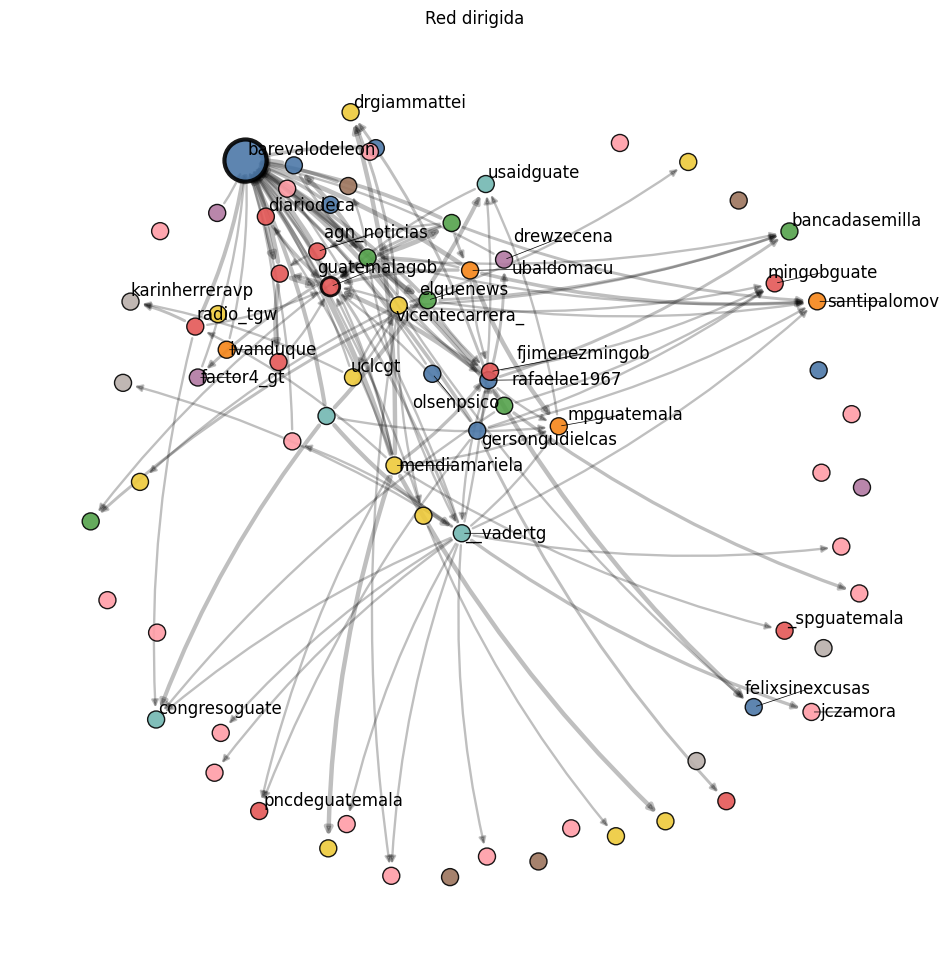

In [148]:
import math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import json
from pyvis.network import Network
from networkx.algorithms.community import louvain_communities

# Cargar edges
try:
    edges
except NameError:
    EDGES_CSV = "../data/network_edges.csv"
    edges = pd.read_csv(EDGES_CSV)

assert set(["source","target","interaction","weight"]).issubset(edges.columns), "Faltan columnas en edges"

# Construir grafo dirigido consolidando pesos y guardando tipos de interacción
G = nx.DiGraph()
for s, t, typ, w in edges[["source","target","interaction","weight"]].itertuples(index=False):
    if s == t:
        continue  # opcional: evitar self-loops
    if G.has_edge(s, t):
        G[s][t]["weight"] += int(w)
        G[s][t]["types"].add(typ)
    else:
        G.add_edge(s, t, weight=int(w), types={typ})

# Métricas base
import pandas as pd
import networkx as nx

# N y E sobre el grafo dirigido
N = G.number_of_nodes()
E = G.number_of_edges()
densidad = nx.density(G)  # enlaces existentes / enlaces posibles 

# Diámetro y clustering se calculan en la versión NO dirigida,
# usando el mayor componente conexo (estándar en redes no fuertemente conexas)
if N > 0 and E > 0:
    in_strength  = dict(G.in_degree(weight="weight"))
    out_strength = dict(G.out_degree(weight="weight"))

    GU = G.to_undirected()

    betweenness   = nx.betweenness_centrality(GU, k=200, seed=42, normalized=True)  # dict
    closeness     = nx.closeness_centrality(GU)                                     # dict
    pagerank_dict = nx.pagerank(G, alpha=0.85, weight="weight")       
    LC_nodes = max(nx.connected_components(GU), key=len)
    Gc = GU.subgraph(LC_nodes).copy()

    # Diámetro exacto; si fuera lento, cae a una aproximación
    try:
        diametro = nx.diameter(Gc)
    except Exception:
        from networkx.algorithms import approximation as apx
        diametro = apx.diameter(Gc)

    clustering_prom = nx.average_clustering(GU, weight="weight")
else:
    diametro = None
    clustering_prom = None

metrics_df = pd.DataFrame([{
    "nodos": N,
    "aristas": E,
    "densidad_dirigida": densidad,
    "diametro_mayor_componente": diametro,
    "clustering_promedio": clustering_prom
}])

display(metrics_df)

# Fuerza de entrada/salida 
top_in = sorted(G.in_degree(weight="weight"), key=lambda x: x[1], reverse=True)[:10]
top_out = sorted(G.out_degree(weight="weight"), key=lambda x: x[1], reverse=True)[:10]

# Centralidades 
bet = nx.betweenness_centrality(GU, k=200, seed=42, normalized=True)
clo = nx.closeness_centrality(GU)
pr  = nx.pagerank(G, alpha=0.85, weight="weight")

def to_df(items, k=10, col="valor"):
    return pd.DataFrame(sorted(items, key=lambda x: x[1], reverse=True)[:k], columns=["usuario", col])

top_in_items  = sorted(in_strength.items(),  key=lambda x: x[1], reverse=True)[:10]
top_out_items = sorted(out_strength.items(), key=lambda x: x[1], reverse=True)[:10]

display(
    pd.DataFrame(top_in_items,  columns=["usuario","in_strength"]),
    pd.DataFrame(top_out_items, columns=["usuario","out_strength"]),
    to_df(list(betweenness.items()),   col="betweenness"),
    to_df(list(closeness.items()),     col="closeness"),
    to_df(list(pagerank_dict.items()), col="pagerank"),
)

# Comunidades 
coms = louvain_communities(GU, weight="weight", seed=42)
# Mapa nodo -> id de comunidad
node2com = {}
for cid, cset in enumerate(sorted(coms, key=len, reverse=True)):
    for n in cset:
        node2com[n] = cid

# Subgrafo visual
topN = 75
top_nodes = [u for u, _ in sorted(in_strength.items(), key=lambda x: x[1], reverse=True)[:topN]]
H = G.subgraph(top_nodes).copy()

net = Network(height="780px", width="100%", directed=True, notebook=True)

opts = {
    "nodes":   {"shape": "dot", "scaling": {"min": 5, "max": 60}},
    "edges":   {"arrows": {"to": {"enabled": True, "scaleFactor": 0.7}}, "smooth": False},
    "physics": {"solver": "forceAtlas2Based", "stabilization": {"iterations": 150}}
}
net.set_options(json.dumps(opts))

# Paleta simple para comunidades
PALETTE = [
    "#4c78a8","#f58518","#e45756","#72b7b2","#54a24b",
    "#eeca3b","#b279a2","#ff9da6","#9d755d","#bab0ab"
]

for n in H.nodes():
    ins  = in_strength.get(n, 0)
    outs = out_strength.get(n, 0)
    pr_v = pagerank_dict.get(n, 0.0)
    btw  = betweenness.get(n, 0.0)
    cid  = node2com.get(n, -1)
    color = PALETTE[cid % len(PALETTE)] if cid >= 0 else "#999999"

    size = 8 + 4*math.log1p(ins)

    border_w = 4 if btw >= 0.05 else 2 if btw >= 0.02 else 1

    title = (
        f"<b>{n}</b><br>"
        f"in_strength: {ins:,}<br>"
        f"out_strength: {outs:,}<br>"
        f"PageRank: {pr_v:.4f}<br>"
        f"Betweenness: {btw:.4f}<br>"
        f"Comunidad: C{cid}"
    )
    net.add_node(n, label=n, title=title, value=size, group=cid, color=color, borderWidth=border_w)

for u, v, data in H.edges(data=True):
    w = int(data.get("weight", 1))
    types = ",".join(sorted(data.get("types", [])))
    # ancho por peso (log)
    width = 1 + math.log1p(w)
    net.add_edge(u, v, value=width, width=width, title=f"{types} · weight={w}", arrows="to")


# PNG estático
import math
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(H, k=0.45, seed=42)

# Tamaño por in_strength
node_sizes = [max(150, 5 * H.in_degree(n, weight="weight")) for n in H.nodes()]
# Color por comunidad
node_colors = [
    PALETTE[node2com.get(n, -1) % len(PALETTE)] if n in node2com else "#999999"
    for n in H.nodes()
]

border_w = []
for n in H.nodes():
    b = betweenness.get(n, 0.0)
    border_w.append(3 if b >= 0.05 else 2 if b >= 0.02 else 1)

# Dibuja nodos
nx.draw_networkx_nodes(
    H, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9,
    edgecolors="black",
    linewidths=border_w
)

# Flechas y grosor por peso (log(1+weight))
edge_widths = [1 + math.log1p(d.get("weight", 1)) for _, _, d in H.edges(data=True)]
nx.draw_networkx_edges(
    H, pos,
    alpha=0.25,
    arrows=True,
    width=edge_widths,
    arrowstyle='-|>',
    arrowsize=10,
    connectionstyle='arc3,rad=0.08'
)

K = 30
label_nodes = [u for u, _ in sorted(in_strength.items(), key=lambda x: x[1], reverse=True)[:K]]

texts = [plt.text(pos[n][0], pos[n][1], n, fontsize=12) for n in label_nodes]
try:
    from adjustText import adjust_text
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', lw=0.5),
        expand_points=(1.2, 1.2),
        expand_text=(1.2, 1.2),
        force_text=0.8,
        force_points=0.5
    )
except ImportError:
    print("instala 'adjustText' para evitar traslapes de etiquetas: pip install adjustText")

plt.title("Red dirigida")
plt.axis("off")


## Identificación y análisis de comunidades

In [2]:
import os
import pandas as pd
import numpy as np

EDGES_CSV = "../data/network_edges.csv"
CLEAN_CSV = "../data/clean_data.csv"

edges = pd.read_csv(EDGES_CSV).fillna("")
edges["source"] = edges["source"].astype(str).str.lower().str.strip()
edges["target"] = edges["target"].astype(str).str.lower().str.strip()
edges["interaction"] = edges["interaction"].astype(str)
edges["weight"] = edges["weight"].astype(int)

# quitar lazos a sí mismo
edges = edges[edges["source"] != edges["target"]].reset_index(drop=True)
edges_agg = (edges.groupby(["source","target"], as_index=False)["weight"].sum())

print(edges_agg.shape)
edges_agg.head(5)

# Cargar texto limpio para caracterización temática
try:
    clean_df = pd.read_csv(CLEAN_CSV).fillna("")
    clean_df["Username"] = clean_df["Username"].astype(str).str.lower().str.strip()
    clean_df["clean_tweet"] = clean_df["clean_tweet"].astype(str)
except Exception as e:
    clean_df = pd.DataFrame(columns=["Username","clean_tweet"])
    print("Aviso: no se pudo cargar clean_data.csv. Temas por comunidad se limitarán si falta este archivo.\n", e)


(12024, 3)


Para la detección de comunidades se utilizará Leiden, ya que es un algoritmo veloz que se usa mucho actualmente. Este algoritmo trabaja en fases sobre un grafo. Primero se encarga del movimiento local de nodos entre comunidades para maximizar una función objetivo. Luego, se hace un refinamiento que divide comunidades mal conectadas, lo que evita tener comunidades mal formadas. Por último se hace la agregación, donde cada comunidad se colapsa dentro de un "supernodo" repetidamente hasta converger. 

In [3]:
import igraph as ig
import leidenalg as la

# Mapear usuarios a índices
users = sorted(set(edges_agg["source"]) | set(edges_agg["target"]))
idx = {u:i for i,u in enumerate(users)}

# Crear grafo dirigido
g_dir = ig.Graph(
    n=len(users),
    edges=[(idx[s], idx[t]) for s,t in zip(edges_agg["source"], edges_agg["target"])],
    directed=True
)
g_dir.vs["name"] = users
g_dir.es["weight"] = edges_agg["weight"].tolist()
g_und = g_dir.as_undirected(combine_edges="sum")

# Partición Leiden (modularidad / RBConfiguration)
partition = la.find_partition(
    g_und,
    la.RBConfigurationVertexPartition,
    weights=g_und.es["weight"]
)

# Comunidad por nodo
comm_ids = np.array(partition.membership)
node_df = pd.DataFrame({
    "user": g_und.vs["name"],
    "community": comm_ids
})

print(f"Comunidades detectadas: {comm_ids.max()+1}")
node_df.head(5)


Comunidades detectadas: 24


,user,community
0,0205mh_,11
1,0515om,0
2,1056_antonio,7
3,10downingstreet,14
4,10elcrack10,4


In [5]:
# Métricas por nodo
pr = g_dir.pagerank(directed=True, weights=g_dir.es["weight"])
deg_in  = g_dir.degree(mode="IN",  loops=False)
deg_out = g_dir.degree(mode="OUT", loops=False)
w_in    = g_dir.strength(weights=g_dir.es["weight"], mode="IN",  loops=False)
w_out   = g_dir.strength(weights=g_dir.es["weight"], mode="OUT", loops=False)

node_df["pagerank"] = pr
node_df["deg_in"]   = deg_in
node_df["deg_out"]  = deg_out
node_df["w_in"]     = w_in
node_df["w_out"]    = w_out

# Tamaño de comunidades
comm_size = node_df.groupby("community").size().rename("n_nodes")

# Aristas internas por comunidad
e_df = edges_agg.merge(node_df.rename(columns={"user":"source"}), on="source")
e_df = e_df.merge(node_df.rename(columns={"user":"target","community":"community_t"}), on="target")
internal = e_df[e_df["community"] == e_df["community_t"]]
comm_edges = (
    internal.groupby("community")
            .agg(n_edges=("weight","size"), w_total=("weight","sum"))
)

# Top 5 influentes por comunidad
topk = (
    node_df.sort_values(["community","pagerank"], ascending=[True, False])
           .groupby("community")
           .head(5)
           .groupby("community")["user"]
           .apply(list)
           .rename("top_influencers")
)

# Unir métricas y rellenar de forma segura
comm_stats = pd.concat([comm_size, comm_edges, topk], axis=1)

# Asegurar columnas numéricas
for col in ["n_edges", "w_total"]:
    if col not in comm_stats.columns:
        comm_stats[col] = 0
    comm_stats[col] = comm_stats[col].fillna(0).astype(int)

# Asegurar listas en top_influencers
if "top_influencers" not in comm_stats.columns:
    comm_stats["top_influencers"] = [[] for _ in range(len(comm_stats))]
else:
    comm_stats["top_influencers"] = comm_stats["top_influencers"].apply(
        lambda x: x if isinstance(x, list) else []
    )

# Orden y reset de índice
comm_stats = (
    comm_stats.sort_values("n_nodes", ascending=False)
              .reset_index()  # 'community' pasa a columna
)

comm_stats.head(10)


,community,n_nodes,n_edges,w_total,top_influencers
0,0,611,827,1925,"[barevalodeleon, gersongudielcas, royalvaradog..."
1,1,301,842,1601,"[ubaldomacu, santipalomov, mpguatemala, marcoa..."
2,2,231,468,836,"[elquenews, bancadasemilla, avillagran502, luc..."
3,3,217,423,774,"[guatemalagob, magaguatemala, karinherreravp, ..."
4,4,208,991,1648,"[fjimenezmingob, mingobguate, pncdeguatemala, ..."
5,5,194,574,867,"[usaidguate, __vadertg, congresoguate, oco_mot..."
6,6,181,632,1061,"[vicentecarrera_, mendiamariela, drgiammattei,..."
7,7,141,813,1059,"[jczamora, prensacomunitar, jlfont001, lahorag..."
8,8,137,319,447,"[drewzecena, emisorasunidas, soy_502, msemilla..."
9,9,114,213,381,"[felixsinexcusas, rafaelae1967, covial_civ, ci..."


In [ ]:
from collections import Counter

# Unir texto limpio a comunidad
if not clean_df.empty:
    text_comm = clean_df.merge(node_df, left_on="Username", right_on="user", how="inner")

    # Filtra tokens menores a 3 caracteres
    def tokens(s):
        return [t for t in str(s).split() if len(t)>=3]
    
    # top 10 términos por comunidad
    topics = (
        text_comm.groupby("community")["clean_tweet"]
                 .apply(lambda col: Counter([tok for s in col for tok in tokens(s)]).most_common(10))
                 .rename("top_terms")
                 .reset_index()
    )
    comm_stats = comm_stats.merge(topics, on="community", how="left")
else:
    comm_stats["top_terms"] = [[]]*len(comm_stats)

# Mostrar caracterización
cols_show = ["community","n_nodes","n_edges","w_total","top_influencers","top_terms"]
comm_stats[cols_show].head(10)


,community,n_nodes,n_edges,w_total,top_influencers,top_terms
0,0,611,827,1925,"[barevalodeleon, gersongudielcas, royalvaradog...","[(barevalodeleon, 933), (presidente, 121), (go..."
1,1,301,842,1601,"[ubaldomacu, santipalomov, mpguatemala, marcoa...","[(barevalodeleon, 608), (ubaldomacu, 397), (sa..."
2,2,231,468,836,"[elquenews, bancadasemilla, avillagran502, luc...","[(barevalodeleon, 297), (bancadasemilla, 130),..."
3,3,217,423,774,"[guatemalagob, magaguatemala, karinherreravp, ...","[(barevalodeleon, 314), (guatemalagob, 211), (..."
4,4,208,991,1648,"[fjimenezmingob, mingobguate, pncdeguatemala, ...","[(barevalodeleon, 416), (fjimenezmingob, 221),..."
5,5,194,574,867,"[usaidguate, __vadertg, congresoguate, oco_mot...","[(barevalodeleon, 275), (vadertg, 198), (congr..."
6,6,181,632,1061,"[vicentecarrera_, mendiamariela, drgiammattei,...","[(barevalodeleon, 312), (vicentecarrera, 149),..."
7,7,141,813,1059,"[jczamora, prensacomunitar, jlfont001, lahorag...","[(barevalodeleon, 288), (cidh, 88), (jczamora,..."
8,8,137,319,447,"[drewzecena, emisorasunidas, soy_502, msemilla...","[(barevalodeleon, 174), (emisorasunidas, 45), ..."
9,9,114,213,381,"[felixsinexcusas, rafaelae1967, covial_civ, ci...","[(barevalodeleon, 160), (felixsinexcusas, 89),..."


In [ ]:
# Mostrar top 5 comunidades por tamaño
def summarize_row(row):
    terms = ", ".join([t for t,_ in (row["top_terms"] or [])][:5]) if isinstance(row["top_terms"], list) else ""
    infl = ", ".join((row["top_influencers"] or [])[:5]) if isinstance(row["top_influencers"], list) else ""
    return pd.Series({
        "Comunidad": int(row["community"]),
        "Nodos": int(row["n_nodes"]),
        "Aristas internas": int(row["n_edges"]),
        "Peso interno": int(row["w_total"]),
        "Influencers (Top 5)": infl,
        "Temas (Top 5)": terms
    })

summary = comm_stats.head(5).apply(summarize_row, axis=1)
summary


,Comunidad,Nodos,Aristas internas,Peso interno,Influencers (Top 5),Temas (Top 5)
0,0,611,827,1925,"barevalodeleon, gersongudielcas, royalvaradogt...","barevalodeleon, presidente, gobierno, usted, p..."
1,1,301,842,1601,"ubaldomacu, santipalomov, mpguatemala, marcoan...","barevalodeleon, ubaldomacu, santipalomov, mpgu..."
2,2,231,468,836,"elquenews, bancadasemilla, avillagran502, lucr...","barevalodeleon, bancadasemilla, elquenews, sam..."
3,3,217,423,774,"guatemalagob, magaguatemala, karinherreravp, m...","barevalodeleon, guatemalagob, karinherreravp, ..."
4,4,208,991,1648,"fjimenezmingob, mingobguate, pncdeguatemala, d...","barevalodeleon, fjimenezmingob, guatemalagob, ..."


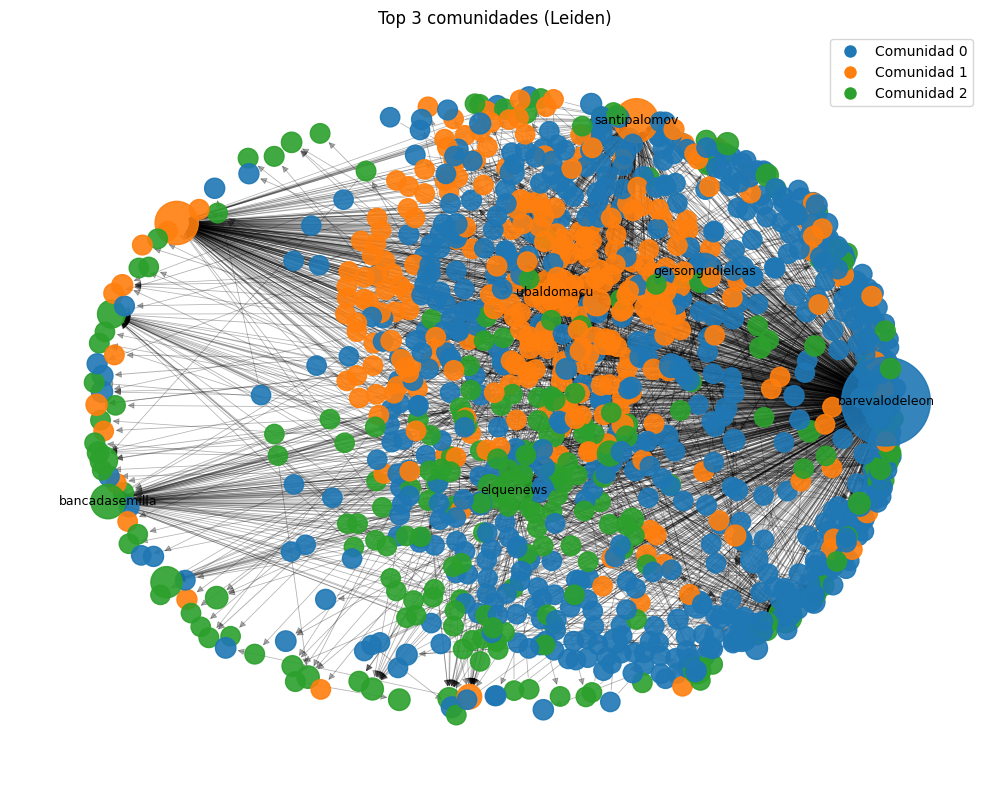

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Top 3 comunidades por tamaño
top3 = comm_stats["community"].head(3).tolist()
nodes_top3 = set(node_df[node_df["community"].isin(top3)]["user"])

# Subgrafo dirigido con edges donde ambos extremos están en top3
sub_edges = edges_agg[edges_agg["source"].isin(nodes_top3) & edges_agg["target"].isin(nodes_top3)]
G = nx.DiGraph()
for u in nodes_top3:
    G.add_node(u, community=int(node_df.loc[node_df["user"]==u, "community"].iloc[0]),
                  pr=float(node_df.loc[node_df["user"]==u, "pagerank"].iloc[0]))

for _, r in sub_edges.iterrows():
    G.add_edge(r["source"], r["target"], weight=int(r["weight"]))

# Layout
pos = nx.spring_layout(G, k=0.7, iterations=100, seed=42)

# Colores por comunidad
comms = sorted(top3)
color_map = {comms[i]: c for i,c in enumerate(plt.cm.tab10.colors[:len(comms)])}
node_colors = [color_map[G.nodes[n]["community"]] for n in G.nodes()]

# Tamaño de nodo
pr_vals = np.array([G.nodes[n]["pr"] for n in G.nodes()])
if pr_vals.max() > 0:
    sizes = 4000 * (pr_vals / pr_vals.max())**0.5 + 80
else:
    sizes = np.full(len(G.nodes()), 80.0)

plt.figure(figsize=(10,8))
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=[0.5 + 2*G[u][v]["weight"]/max(1, sub_edges["weight"].max()) for u,v in G.edges()], alpha=0.3, arrows=True)
labels = {}
for c in top3:
    members = [n for n in G.nodes() if G.nodes[n]["community"]==c]
    top2 = sorted(members, key=lambda n: G.nodes[n]["pr"], reverse=True)[:2]
    for n in top2:
        labels[n] = n
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

from matplotlib.lines import Line2D
legend_elems = [Line2D([0],[0], marker='o', color='w', label=f"Comunidad {c}",
                        markerfacecolor=color_map[c], markersize=10) for c in top3]
plt.legend(handles=legend_elems, loc="best")
plt.title("Top 3 comunidades (Leiden)")
plt.axis("off")
plt.tight_layout()
plt.show()


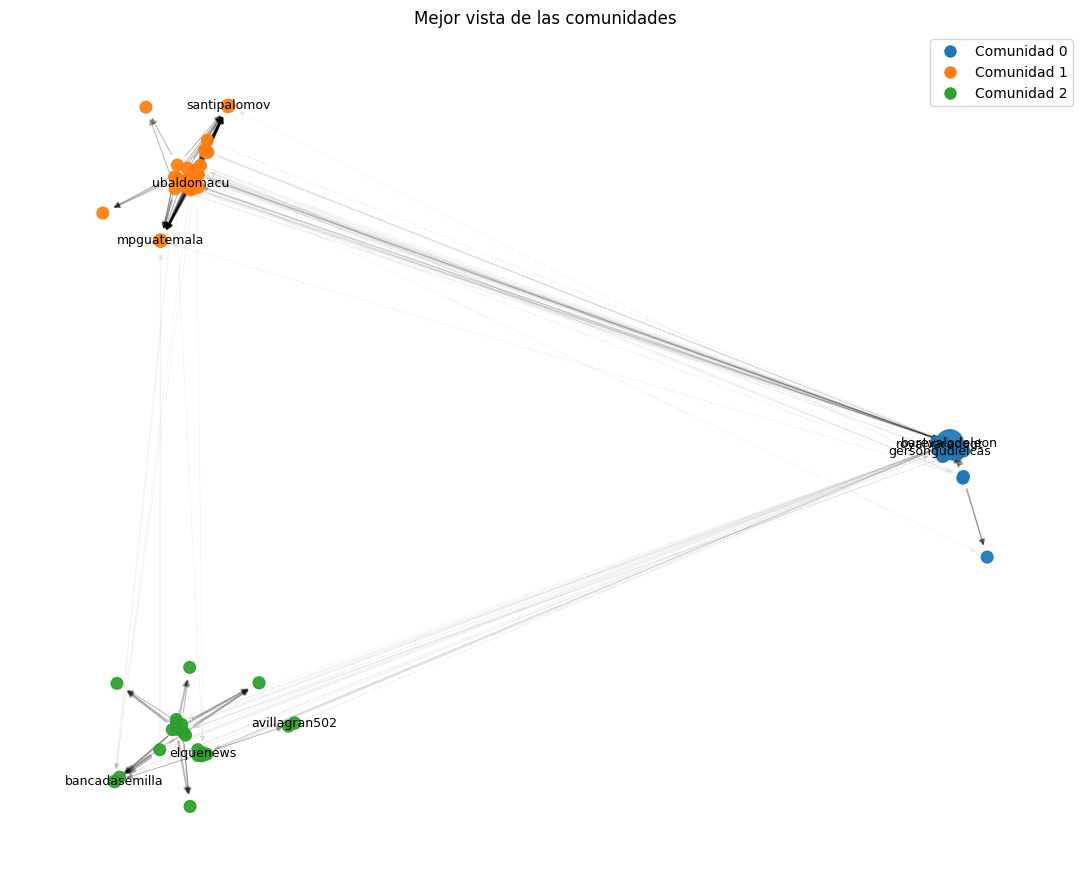

Nodos: 95 | Aristas: 297 | Cuantil usado ≥0.40 | Comunidad enfocada: C0


In [18]:
"""
Esta parte es para ver el grafo anterior más claro por lo que los parámetros se pueden cambiar
"""
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ===== Parámetros =====
TOP_K_PER_COMM          = 60    # nodos por comunidad (por PageRank)
EDGE_WEIGHT_Q_START     = 0.80  # cuantil inicial de peso de arista
EDGE_WEIGHT_Q_MIN       = 0.40  # cuantil mínimo permitido (relaja si hay pocas aristas)
TARGET_EDGES_PER_NODE   = 2.0   # densidad objetivo (~ aristas ≈ nodos * este factor)
MAX_OUT_EDGES_PER_NODE  = 8     # máx. aristas salientes por nodo (0 = sin tope)
MAX_IN_EDGES_PER_NODE   = 8     # máx. aristas entrantes por nodo (0 = sin tope)
K_CORE                  = 2     # 0/1/2... núcleo cohesivo (sube para limpiar hojas)
LABELS_PER_COMM         = 3     # labels por comunidad (los de mayor PageRank)
COMM_GAP_SCALE          = 10.0  # distancia entre comunidades (sube si se enciman grupos)
INNER_ALGO              = "spring"  # "spring" o "kk" (layout interno por comunidad)
INNER_K_MULT            = 2.2   # repulsión interna (spring): >1 separa más
INNER_SCALE             = 2.2   # escala de la nube interna (tamaño del grupo)
FOCUS_INNER_K_MULT      = 3.5   # repulsión extra para la comunidad dominante
FOCUS_INNER_SCALE       = 3.2   # expansión extra para la comunidad dominante
INTRA_ALPHA             = 0.28  # opacidad intra-comunidad
INTER_ALPHA             = 0.05  # opacidad inter-comunidad (muy tenue)
JITTER_STD              = 0.04  # ruido pequeño para evitar superposición exacta
SEED                    = 42

# Utilidades
def layout_comunidad(Gc, algo="spring", k_mult=2.0, seed=42):
    """Layout interno para un subgrafo de una comunidad."""
    if Gc.number_of_nodes() <= 2:
        return {n: np.array([i, 0.0]) for i, n in enumerate(Gc.nodes())}
    if algo.lower() == "kk":
        pos = nx.kamada_kawai_layout(Gc, weight="weight")
    else:
        k = k_mult * 1.0 / np.sqrt(max(1, Gc.number_of_nodes()))
        pos = nx.spring_layout(Gc, weight="weight", k=k, iterations=220, seed=seed)
    return pos

# 1) Top 3 comunidades por tamaño y selección de nodos
top3 = (comm_stats.sort_values("n_nodes", ascending=False)
                 .head(3)["community"].tolist())

nodes_sel = set()
for c in top3:
    members = node_df[node_df["community"] == c]
    topk = (members.sort_values("pagerank", ascending=False)
                    .head(TOP_K_PER_COMM)["user"].tolist())
    nodes_sel.update(topk)

# 2) Subconjunto de aristas entre esos nodos
sub_edges = edges_agg[edges_agg["source"].isin(nodes_sel) &
                      edges_agg["target"].isin(nodes_sel)].copy()
if sub_edges.empty:
    raise RuntimeError("Sin aristas tras la selección. Sube TOP_K_PER_COMM o revisa filtros previos.")

# 3) Filtrado adaptativo por peso para densidad razonable
q = EDGE_WEIGHT_Q_START
min_edges_needed = int(len(nodes_sel) * TARGET_EDGES_PER_NODE)
while True:
    thr = max(1.0, float(sub_edges["weight"].quantile(q)))
    pruned = sub_edges[sub_edges["weight"] >= thr]
    if len(pruned) >= min_edges_needed or q <= EDGE_WEIGHT_Q_MIN:
        sub_edges = pruned.reset_index(drop=True)
        break
    q -= 0.05  # relaja umbral poco a poco

# 4) Limitar aristas por nodo
if MAX_OUT_EDGES_PER_NODE and MAX_OUT_EDGES_PER_NODE > 0:
    sub_edges = (sub_edges.sort_values(["source","weight"], ascending=[True, False])
                           .groupby("source", as_index=False)
                           .head(MAX_OUT_EDGES_PER_NODE))
if MAX_IN_EDGES_PER_NODE and MAX_IN_EDGES_PER_NODE > 0:
    keep_in = (sub_edges.sort_values(["target","weight"], ascending=[True, False])
                         .groupby("target", as_index=False)
                         .head(MAX_IN_EDGES_PER_NODE))
    sub_edges = pd.concat([sub_edges, keep_in], ignore_index=True).drop_duplicates()

# 5) Construir grafo reducido, quitar aislados y aplicar k-core
G = nx.DiGraph()
attrs = (node_df.set_index("user")[["community","pagerank"]]).to_dict(orient="index")
for u in nodes_sel:
    if u in attrs:
        G.add_node(u, community=int(attrs[u]["community"]), pr=float(attrs[u]["pagerank"]))
for _, r in sub_edges.iterrows():
    G.add_edge(r["source"], r["target"], weight=int(r["weight"]))

# quitar aislados
G.remove_nodes_from(list(nx.isolates(G)))

# k-core sobre versión no dirigida para cohesión
if K_CORE and G.number_of_nodes() > 0:
    core_nodes = nx.k_core(G.to_undirected(), k=K_CORE).nodes()
    G = G.subgraph(core_nodes).copy()

# 6) Layout por comunidad con expansión para la dominante
rng = np.random.default_rng(SEED)
node2comm = {n: int(G.nodes[n]["community"]) for n in G.nodes()}
comms = sorted({node2comm[n] for n in G.nodes()})
if not comms:
    raise RuntimeError("El grafo quedó vacío; afloja filtros o baja K_CORE.")

focus_comm = int(comm_stats.sort_values("n_nodes", ascending=False).iloc[0]["community"])

angles = np.linspace(0, 2*np.pi, len(comms), endpoint=False)
centers = {c: np.array([np.cos(a), np.sin(a)])*COMM_GAP_SCALE for c, a in zip(comms, angles)}

pos = {}
for c in comms:
    members = [n for n in G.nodes() if node2comm[n] == c]
    SG = G.subgraph(members)
    # layout interno base
    k_mult = FOCUS_INNER_K_MULT if c == focus_comm else INNER_K_MULT
    inner  = layout_comunidad(SG, algo=INNER_ALGO if c != focus_comm else "spring",
                              k_mult=k_mult, seed=SEED)
    # normalizar y escalar
    X = np.array([inner[n] for n in SG.nodes()])
    X -= X.mean(axis=0)
    span = np.linalg.norm(X, axis=1).max() or 1.0
    scale = FOCUS_INNER_SCALE if c == focus_comm else INNER_SCALE
    X = (X / span) * scale
    for n, vec in zip(SG.nodes(), X):
        pos[n] = centers[c] + vec

# jitter fino para evitar superposición exacta
for n in G.nodes():
    pos[n] = pos[n] + rng.normal(0, JITTER_STD, size=2)

# 7) Dibujo
palette = plt.cm.tab10.colors
color_map = {c: palette[i % len(palette)] for i, c in enumerate(comms)}
node_colors = [color_map[G.nodes[n]["community"]] for n in G.nodes()]

# Tamaño por PageRank
pr_vals = np.array([G.nodes[n]["pr"] for n in G.nodes()])
sizes = 450 * (np.log1p(pr_vals / (pr_vals.max() if pr_vals.max() > 0 else 1))) + 70

intra_edges = [(u, v) for u, v in G.edges() if node2comm[u] == node2comm[v]]
inter_edges = [(u, v) for u, v in G.edges() if node2comm[u] != node2comm[v]]

max_w = int(sub_edges["weight"].max()) if not sub_edges.empty else 1
max_w = max(1, max_w)

plt.figure(figsize=(11, 9))
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_colors, alpha=0.93)

# inter-comunidad muy tenue
nx.draw_networkx_edges(
    G, pos, edgelist=inter_edges,
    width=[0.5 + 2*G[u][v]["weight"]/max_w for u, v in inter_edges],
    alpha=INTER_ALPHA, arrows=True, arrowsize=8,
)

# intra-comunidad más marcada
nx.draw_networkx_edges(
    G, pos, edgelist=intra_edges,
    width=[0.6 + 3.5*G[u][v]["weight"]/max_w for u, v in intra_edges],
    alpha=INTRA_ALPHA, arrows=True, arrowsize=9,
)

# etiquetas: top por PR de cada comunidad
labels = {}
for c in comms:
    members = [n for n in G.nodes() if node2comm[n] == c]
    top_lab = sorted(members, key=lambda n: G.nodes[n]["pr"], reverse=True)[:LABELS_PER_COMM]
    for n in top_lab:
        labels[n] = n
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

# leyenda
from matplotlib.lines import Line2D
legend_elems = [Line2D([0],[0], marker='o', color='w', label=f"Comunidad {c}",
                        markerfacecolor=color_map[c], markersize=10) for c in comms]
plt.legend(handles=legend_elems, loc="best")

plt.title(f"Mejor vista de las comunidades")
plt.axis("off")
plt.tight_layout()
plt.show()

print(f"Nodos: {G.number_of_nodes()} | Aristas: {G.number_of_edges()} | Cuantil usado ≥{q:.2f} | "
      f"Comunidad enfocada: C{focus_comm}")


